In [2]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from google.colab import files
uploaded = files.upload()

Saving clean_dataset.csv to clean_dataset.csv


In [5]:
"""
Preprocessing steps
"""

import re
from sklearn.feature_extraction.text import TfidfVectorizer

data = pd.read_csv("clean_dataset.csv")
expected_columns = ['id', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Label']

# Filter out rows that don't have all the expected columns
data = data.dropna(subset=expected_columns)

data = data.drop(['id'], axis=1)

categories = ["Siblings", "Co-worker", "Partner", "Friends"]
for category in categories:
    data[category] = data['Q5'].apply(lambda x: 1 if isinstance(x, str) and category in x.split(',') else 0)

# Drop the original 'Q5' column
data = data.drop(['Q5'], axis=1)

def extract_rankings(text):
    rankings = dict(item.split('=>') for item in text.split(','))
    return {k: int(v) if v else 0 for k, v in rankings.items()}

# Apply the function to the 'Q6' column and expand it into multiple columns
rankings_df = data['Q6'].apply(extract_rankings).apply(pd.Series)

# Concatenate the new columns with the original DataFrame, dropping the 'Q6' column
data = pd.concat([data.drop('Q6', axis=1), rankings_df], axis=1)

numeric_columns = ['Q7', 'Q8', 'Q9']
for col in numeric_columns:
    if data[col].dtype == object:  # Check if the column is of object (string) type
        data[col] = data[col].str.replace(',', '').astype(float)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Keep alphanumeric characters only (including spaces)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return text

data['Q10'] = [clean_text(text) for text in data['Q10']]

df = pd.DataFrame(data)

tfidf_vectorizer = TfidfVectorizer(max_features=100,  # Limit the number of features to keep
                                   ngram_range=(1, 1),  # Consider both unigrams and bigrams
                                   stop_words='english', min_df=5)  # Remove common 'stop words'

Q10_tfidf = tfidf_vectorizer.fit_transform(data['Q10']).toarray()
Q10_tfidf_df = pd.DataFrame(Q10_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
data = data.drop(['Q10'], axis=1)
data = pd.concat([data, Q10_tfidf_df], axis=1)

# Save DataFrame to CSV
data.to_csv('my_dataframe.csv', index=False)  # Set index=False if you do not want to write row indices to the CSV file

# Use the google.colab library to download the file to your local machine
data = data.dropna()
#from google.colab import files
#files.download('my_dataframe.csv')

print(data.head())

    Q1   Q2   Q3   Q4    Q7    Q8     Q9  Label  Siblings  Co-worker  ...  \
0  4.0  1.0  2.0  1.0  25.0   7.0  100.0  Dubai       0.0        1.0  ...   
1  4.0  3.0  5.0  2.0  20.0   3.0    4.0  Dubai       0.0        1.0  ...   
2  5.0  4.0  5.0  1.0  32.0   5.0    4.0  Dubai       0.0        0.0  ...   
3  5.0  4.0  4.0  1.0  23.0  10.0    3.0  Dubai       0.0        0.0  ...   
4  4.0  3.0  3.0  3.0  20.0  10.0    5.0  Dubai       1.0        0.0  ...   

   walking  wall  want  welcome  work  world  worlds  yeah  years  york  
0      0.0   0.0   0.0      0.0   0.0    0.0     0.0   0.0    0.0   0.0  
1      0.0   0.0   0.0      0.0   0.0    0.0     0.0   0.0    0.0   0.0  
2      0.0   0.0   0.0      0.0   0.0    0.0     0.0   0.0    0.0   0.0  
3      0.0   0.0   0.0      0.0   0.0    0.0     0.0   0.0    0.0   0.0  
4      0.0   0.0   0.0      0.0   0.0    0.0     0.0   0.0    0.0   0.0  

[5 rows x 118 columns]


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.9091746454975155


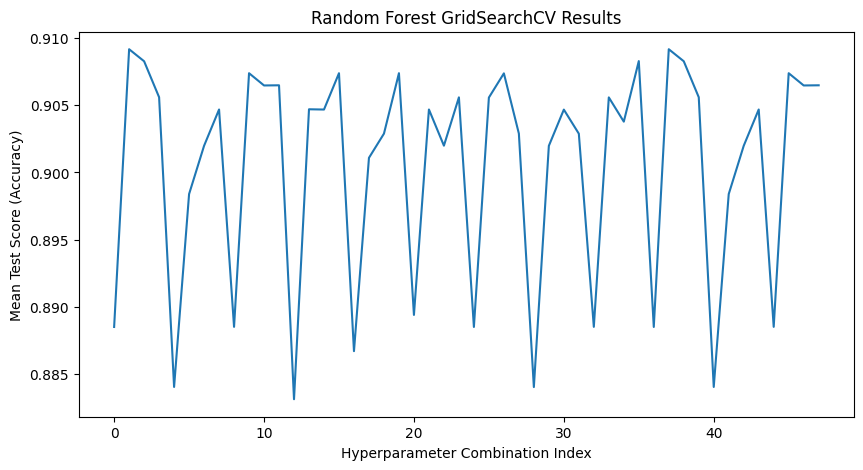

Test Accuracy: 0.9280575539568345


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming data is your DataFrame and already defined as before
X = data.drop(['Label'], axis=1)
y = data['Label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomForest and GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plotting the mean test scores
plt.figure(figsize=(10, 5))
plt.plot(results['mean_test_score'])
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Random Forest GridSearchCV Results')
plt.show()

# Print the test accuracy
print("Test Accuracy:", test_accuracy)
